# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

### Загрузка и подготовка данных

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
nltk.download('popular')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from tqdm import notebook
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
nltk.download('wordnet')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Откроем датасет и изучим его

In [ ]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Изучим количество токсичных и не токсичных комментариев

0    143106
1     16186
Name: toxic, dtype: int64


<Axes: xlabel='toxic', ylabel='count'>

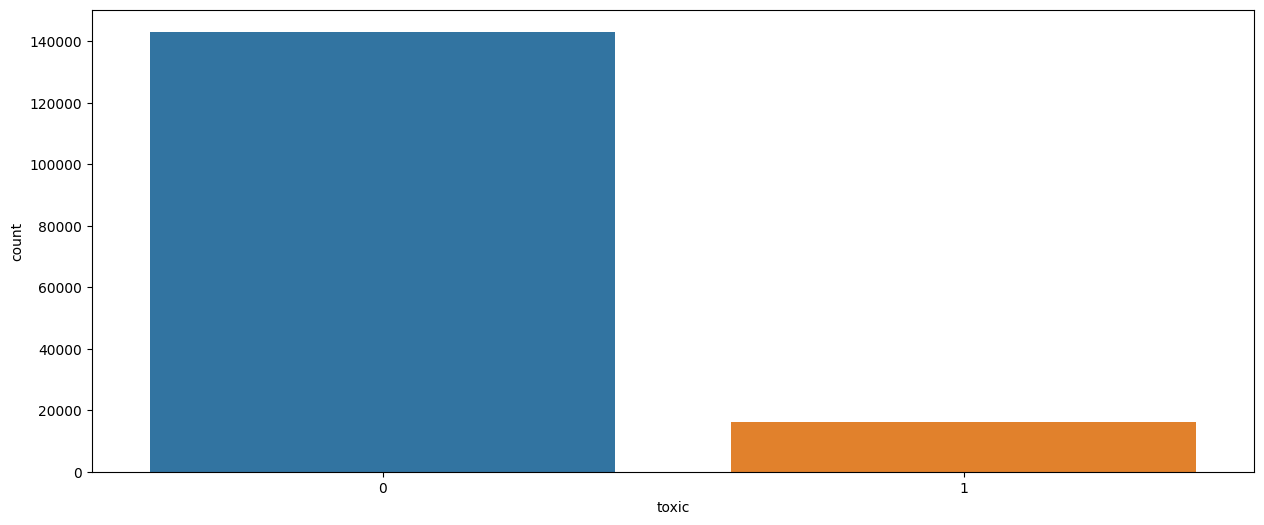

In [ ]:
print(data['toxic'].value_counts())
zeroes = data['toxic'].value_counts()[0]
ones = data['toxic'].value_counts()[1]

plt.figure(figsize=(15, 6))
sns.countplot(x='toxic', data=data)

Классы не сбалансированы.


<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано верно. Отлично, что векторизатор был обучен только на тренировочной части данных.
</div>

In [ ]:
RANDOM_STATE = 12345

Создадим уменьшенный датасет для того, что бы при обучении модели не тормозили

In [ ]:
data_cut = data.sample(len(data)//3, random_state=RANDOM_STATE).reset_index()

Еще раз проверим баланс классов

0    47673
1     5424
Name: toxic, dtype: int64


<Axes: xlabel='toxic', ylabel='count'>

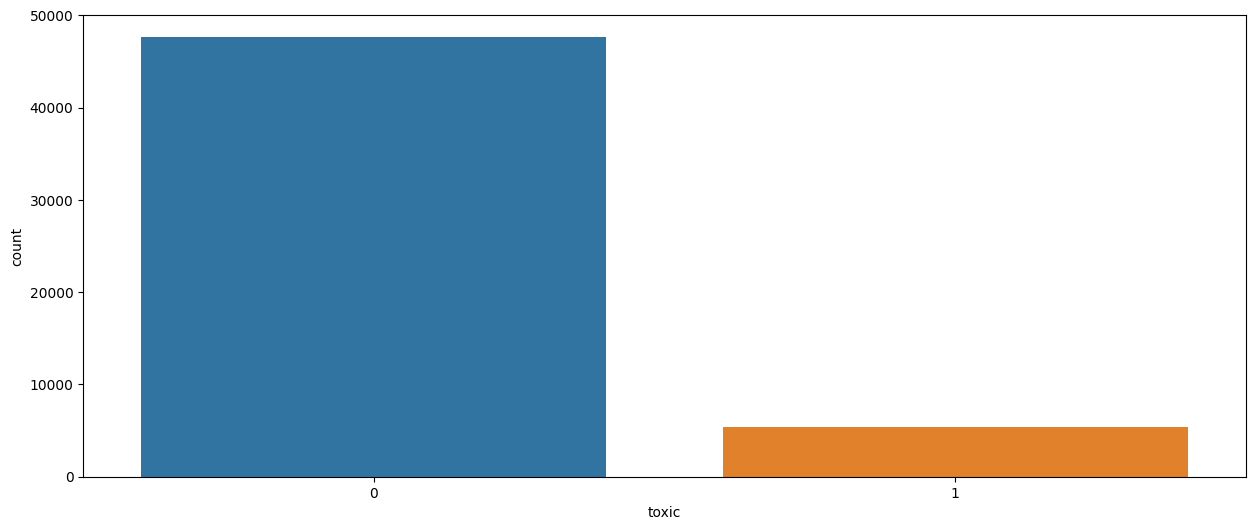

In [ ]:
print(data_cut['toxic'].value_counts())
zeroes = data_cut['toxic'].value_counts()[0]
ones = data_cut['toxic'].value_counts()[1]

plt.figure(figsize=(15, 6))
sns.countplot(x='toxic', data=data_cut)

Объявим корпус текстов:

In [ ]:
corpus = data_cut['text']
print(corpus[0])

Expert Categorizers  

Why is there no mention of the fact that Nazis were particularly great categorizers? They excelled in identifying various things and writing about them and putting them in their proper places.


<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Приводить тексты к юникоду не имеет смысла, так как они все на английском. Это может привести к падению ядра из-за увеличения объема занимаемой памяти.
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Привет! Спасибо за ревью! Сейчас успеваю отработать только "красные" замечания, т.к. завтра дедлайн. Все остальное обязательно изучу позже.
    Были внесены следующие изменения - удалила часть кода: .values.astype('U')
</div>

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> ОК.
</div>

ввожу функцию очищения текстов постов:

In [ ]:
# функция лемматизации и токенизации
def get_lemma(text):
    # импорты для pandarallel
    import nltk
    from nltk.corpus import wordnet

    # оставляем только латинские символы и апостроф, использующийся в английских словах
    ret = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z\']+')
    tokens = ret.tokenize(text)
    lemma = []
    wnl = nltk.stem.WordNetLemmatizer()
    # лемматизация с использованим частей речи
    for token in tokens:
         # раскрытие списка результатов после POS-теггинга, взятие POS, взятие начальной буквы из POS
        tag = nltk.pos_tag([token])[0][1][0].upper()
        # пользовательский словарь тегов POS
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        # получение нужного POS-тега или тега сущиствительного по умолчанию
        wordnet_pos = tag_dict.get(tag, wordnet.NOUN)
        lemma.append(wnl.lemmatize(token, wordnet_pos))
    # воссоздание текста из списка лемм
    return str.lower(' '.join(map(str, lemma)))

Проверка функции лемматизации

In [ ]:
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
test_df = pd.DataFrame([sentence1, sentence2], columns=['text'])

test_df['text'].apply(get_lemma)

0    the strip bat be hang on their foot for best
1       you should be ashamed of yourself go work
Name: text, dtype: object

In [ ]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = ' '.join(text.split())
    return text

Очищаю тексты постов

In [ ]:
data_cut['text'] = data_cut['text'].apply(clear_text)

Леммализирую тексты постов

In [ ]:
data_cut['text'] = data_cut['text'].apply(get_lemma)

В цикле применим функцию для очистки и лемматизации текстов "clear_text":

In [ ]:
for i in tqdm(range(len(corpus))):
    corpus[i] = clear_text(corpus[i])

100%|██████████| 53097/53097 [01:22<00:00, 647.37it/s] 


Добавим корпус к датасету

In [ ]:
data_corpus = pd.DataFrame(corpus)

In [ ]:
data_corpus['text'] = data_corpus['text'].apply(get_lemma)


In [ ]:
data_corpus

,text
0,expert categorizers why be there no mention of...
1,noise fart talk
2,an indefinite block be appropriate even for a ...
3,i don t understand why we have a screenshot of...
4,hello some of the people place or thing you ha...
...,...
53092,january utc centrifugal force citation
53093,i remove the prod because although a translati...
53094,the link about bunjevs above explains the whol...
53095,but you don t live here so how can you know lo...


In [ ]:
data_cut['lemm_text'] = data_corpus

In [ ]:
display(data_cut.head(10))
data_cut.info()

,index,Unnamed: 0,text,toxic,lemm_text
0,109486,109583,expert categorizers why is there no mention of...,0,expert categorizers why be there no mention of...
1,104980,105077,noise fart talk,1,noise fart talk
2,82166,82244,an indefinite block is appropriate even for a ...,0,an indefinite block be appropriate even for a ...
3,18721,18740,i don t understand why we have a screenshot of...,0,i don t understand why we have a screenshot of...
4,128178,128310,hello some of the people places or things you ...,0,hello some of the people place or thing you ha...
5,108309,108406,if you read carefully my comment was overall a...,1,if you read carefully my comment be overall a ...
6,25259,25283,did you make it at wp ae ofshalott,0,do you make it at wp ae ofshalott
7,32655,32695,know as much as he thinks,0,know a much a he think
8,31896,31936,thank you for your comment and willingness to ...,0,thank you for your comment and willingness to ...
9,20224,20244,update hey yall im going to be gone a week so ...,0,update hey yall im go to be go a week so dont ...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53097 entries, 0 to 53096
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       53097 non-null  int64 
 1   Unnamed: 0  53097 non-null  int64 
 2   text        53097 non-null  object
 3   toxic       53097 non-null  int64 
 4   lemm_text   53097 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.0+ MB


Определяем фичи и целевой признак, разделяем датасет на тренировочную и тестовую выборки:

In [ ]:
features = data_cut['lemm_text']
target = data_cut['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify = target)

Объявим стоп-слова

In [ ]:
nltk.download('stopwords')
stopwords1 = list(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tf-idf

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords1)
print(count_tf_idf)

TfidfVectorizer(stop_words=['hasn', 'had', 'myself', 'her', 's', 'what',
                            "wasn't", 'which', 'it', 'most', "mightn't",
                            "you'll", 'here', 'or', 'just', 'those', 'off', 'i',
                            "shan't", 'yours', 'hers', 'whom', 'under', 't',
                            "don't", 'aren', 'should', 'each', "hadn't", 'no', ...])


In [ ]:
features_train = count_tf_idf.fit_transform(features_train)
features_test = count_tf_idf.transform(features_test)

Посмотри на размеры выборок

In [ ]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(39822, 65895)
(13275, 65895)
(39822,)
(13275,)


Вывод:
- Мне в работу был передан датасет содержащий почти 160 тыс комментариев из интернета, содержащий признак, является комментарий токсичным или нет
- Датасет полный, пропусков нет.
- Я взяла сэмпл из датасета в размере 50 тыс строк, для того, что бы оптимизировать время обучения моделей.
- Провела очистку текста и лемматизацию.

<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано верно. Отлично, что векторизатор был обучен только на тренировочной части данных.
</div>

### Обучение

### LogisticRegression

In [ ]:
lr = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 12],
                'max_iter':[100, 500, 1000],
                'class_weight':(['balanced'])}]

clf = GridSearchCV(lr, hyperparams, scoring='f1')
clf.fit(features_train, target_train)
print("Best parameters:")
print()
print(clf.best_params_)
print()
print("F1 grid scores:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))

Best parameters:

{'C': 12, 'class_weight': 'balanced', 'max_iter': 100, 'solver': 'lbfgs'}

F1 grid scores:

0.701007 for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'solver': 'newton-cg'}
0.701007 for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'solver': 'lbfgs'}
0.700626 for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'solver': 'liblinear'}
0.701007 for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'newton-cg'}
0.701007 for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'lbfgs'}
0.700626 for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'liblinear'}
0.701007 for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'newton-cg'}
0.701007 for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'lbfgs'}
0.700626 for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'liblinear'}
0.736760 for {'C': 1, 'class_weight': 'balanced', 'max_iter': 100, 'sol

<div class="alert alert-block alert-info">
<b>Совет: </b> Напомню, что внутри кросс-валидации происходит разбиение выборки на треин и валидацию. Однако, в таком случае векторизатор обучен на всей выборке, а это не совсем корректно. Для избежания такого эффекта можно использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">пайплайн</a>. <a href="https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05">Тут</a> есть пример.
</div>

### CatBoost

In [ ]:
Catboost = CatBoostClassifier(verbose=False, iterations=250)
Catboost.fit(features_train, target_train)

In [ ]:
target_predict = Catboost.predict(features_test)
cv_CBC = cross_val_score(Catboost,
                                         features_train,
                                         target_train,
                                         cv=6,
                                         scoring='f1').mean()
test_f1_CBC = f1_score(target_test, target_predict)
print('F1 на cv', test_f1_CBC)

F1 на cv 0.7307861220904699


### RidgeClassifier

In [ ]:
ridge = RidgeClassifier(alpha=1.0)
hyperparams = [{'max_iter':[20, 40, 60, 250, 100, 700, 1200, 1300, 1400, 1600],
                'solver':['auto', 'lsqr', 'sparse_cg'],
                'class_weight':(['balanced'])}]
gsr = GridSearchCV(ridge, hyperparams, scoring='f1')
gsr.fit(features_train, target_train)

GridSearchCV(estimator=RidgeClassifier(),
             param_grid=[{'class_weight': ['balanced'],
                          'max_iter': [20, 40, 60, 250, 100, 700, 1200, 1300,
                                       1400, 1600],
                          'solver': ['auto', 'lsqr', 'sparse_cg']}],
             scoring='f1')

In [ ]:
print("Best parameters:")
print()
print(gsr.best_params_)
print()
print("F1 grid scores:")
print()
means = gsr.cv_results_['mean_test_score']
stds = gsr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsr.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))

Best parameters:

{'class_weight': 'balanced', 'max_iter': 20, 'solver': 'lsqr'}

F1 grid scores:

0.687722 for {'class_weight': 'balanced', 'max_iter': 20, 'solver': 'auto'}
0.689105 for {'class_weight': 'balanced', 'max_iter': 20, 'solver': 'lsqr'}
0.687722 for {'class_weight': 'balanced', 'max_iter': 20, 'solver': 'sparse_cg'}
0.687722 for {'class_weight': 'balanced', 'max_iter': 40, 'solver': 'auto'}
0.687718 for {'class_weight': 'balanced', 'max_iter': 40, 'solver': 'lsqr'}
0.687722 for {'class_weight': 'balanced', 'max_iter': 40, 'solver': 'sparse_cg'}
0.687722 for {'class_weight': 'balanced', 'max_iter': 60, 'solver': 'auto'}
0.687718 for {'class_weight': 'balanced', 'max_iter': 60, 'solver': 'lsqr'}
0.687722 for {'class_weight': 'balanced', 'max_iter': 60, 'solver': 'sparse_cg'}
0.687722 for {'class_weight': 'balanced', 'max_iter': 250, 'solver': 'auto'}
0.687718 for {'class_weight': 'balanced', 'max_iter': 250, 'solver': 'lsqr'}
0.687722 for {'class_weight': 'balanced', 'max_i

Подведем итоги

In [ ]:
index = ['LogisticRegression',
         'CatBoostClassifier',
         'RidgeClassifier']
data_f1 = {'F1 на CV':[clf.best_score_,
                    cv_CBC,
                    gsr.best_score_],
        }

scores_data = pd.DataFrame(data=data_f1, index=index)
scores_data

,F1 на CV
LogisticRegression,0.747519
CatBoostClassifier,0.717041
RidgeClassifier,0.689105


<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что попробовал разные модели в этом шаге!
</div>

Протестируем LogisticRegression на тестовой выборке:

In [ ]:
lr_best_params_ = clf.best_params_

In [ ]:
#Обучаю модель на оптимальных гиперпараметрах
lr = LogisticRegression()

lr.set_params(**lr_best_params_)
lr.fit(features_train, target_train)
lr_model_predictions = lr.predict(features_test)
f1_LR = f1_score(target_test, lr_model_predictions)

print('F1 модели LogisticRegression:', f1_LR)

F1 модели LogisticRegression: 0.7539007092198581


## Вывод:

- Мне в работу был передан датасет содержащий почти 160 тыс комментариев из интернета, содержащий признак, является комментарий токсичным или нет
- Датасет полный, пропусков нет.
- Я взяла сэмпл из датасета в размере 50 тыс строк, для того, что бы оптимизировать время обучения моделей.
- Провела очистку текста и лемматизацию.
- Обучила три модели машинного обучения и замерила метрику f1.
- Логистическая регрессия на тесте показывает  f1>0,75 что соотвествует условиям задачи. Для данной задари рекомендую использовать данную модель, с параметрами: 'C': 12, 'class_weight': 'balanced', 'max_iter': 100, 'solver': 'lbfgs'.
